In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import os
from google.colab import files, drive
from PIL import Image

In [ ]:
# Mount Google Drive (only once)
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
# Constants
IMG_SIZE = (299, 299)  # Xception input size
BATCH_SIZE = 32
EPOCHS = 15
DATA_DIR = '/content/drive/MyDrive/MORE DATASETS'  # Update with your dataset path in Google Drive
CLASS_NAMES = {0: 'fake', 1: 'real'}  # Explicit class mapping (0 = Fake, 1 = Real)

In [ ]:
# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

In [ ]:
# Load and preprocess training data
train_generator = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training',
    shuffle=True
)

Found 3200 images belonging to 2 classes.


In [ ]:
# Load and preprocess validation data
validation_generator = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    shuffle=False
)

Found 800 images belonging to 2 classes.


In [ ]:
# Verify class indices to ensure 0 = Fake, 1 = Real
print("Class indices:", train_generator.class_indices)

Class indices: {'fake': 0, 'real': 1}


In [ ]:
# Build XceptionNet model
def create_xception_model():
    # Load pre-trained Xception model
    base_model = Xception(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

    # Freeze base model layers
    base_model.trainable = False

    # Add custom layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    predictions = Dense(1, activation='sigmoid')(x)  # Sigmoid for binary classification

    # Create final model
    model = Model(inputs=base_model.input, outputs=predictions)

    return model

In [ ]:
# Create and compile model
model = create_xception_model()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [ ]:
# Model summary
model.summary()

# Callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ModelCheckpoint(
        '/content/drive/MyDrive/xception_deepfake4000_best.h5',  # Save to Google Drive
        monitor='val_accuracy',
        save_best_only=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3
    )
]

NameError: name 'model' is not defined

In [ ]:
# Train the model
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    callbacks=callbacks
)

NameError: name 'model' is not defined

In [ ]:
# Evaluate the model
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

NameError: name 'model' is not defined

In [ ]:
# Function to predict on a single image
def predict_deepfake(image_path, model):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=IMG_SIZE)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) / 255.0

    prediction = model.predict(img_array)
    score = prediction[0][0]
    label = 1 if score >= 0.5 else 0  # Threshold at 0.5 for binary classification
    return {'label': CLASS_NAMES[label], 'confidence': score}

# Example usage of prediction
# image_path = '/content/drive/MyDrive/path_to_test_image.jpg'
# result = predict_deepfake(image_path, model)
# print(f"Prediction: {result['label']}, Confidence: {result['confidence']:.4f}")

In [ ]:
# Save the final model
model.save('/content/drive/MyDrive/xception_deepfake_final4000.h5')

Upload an image for deepfake detection:


Saving valid.jpg to valid.jpg
Uploaded Image:


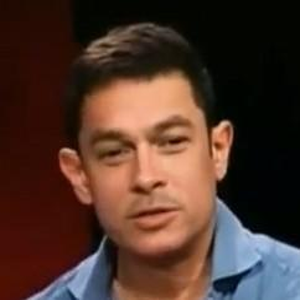

Fake: 72.49%


In [ ]:
from google.colab import drive, files
import tensorflow as tf
from PIL import Image
import io
from IPython.display import display
# # Mount Google Drive
# drive.mount('/content/drive')

# Constants
IMG_SIZE = (299, 299)
MODEL_PATH = '/content/drive/MyDrive/MODELS/4000-Modelaa/xception_deepfake_final4000.h5'  # Update with your model path
CLASS_NAMES = {0: 'Fake', 1: 'Real'}

# Load model
model = tf.keras.models.load_model(MODEL_PATH)

# Process uploaded image
def process_image(uploaded_file):
    img = Image.open(io.BytesIO(uploaded_file))
    temp_path = '/tmp/image.jpg'
    img.save(temp_path)
    return temp_path

# Predict deepfake
def predict_deepfake(image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=IMG_SIZE)
    img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
    img_array = tf.expand_dims(img_array, 0)
    score = model.predict(img_array, verbose=0)[0][0]
    label = 1 if score >= 0.5 else 0
    probability = score if label == 1 else 1 - score
    return CLASS_NAMES[label], probability

# Upload and predict
print("Upload an image for deepfake detection:")
uploaded = files.upload()
fn = list(uploaded.keys())[0]
image_path = process_image(uploaded[fn])
# Show uploaded image
img = Image.open(image_path)
print("Uploaded Image:")
img_resized = img.resize((300, 300))
display(img_resized)
label, prob = predict_deepfake(image_path)
print(f"{label}: {100 * prob:.2f}%")